### Data Preprocessing

In [4]:
from preprocessing_withval import Makeloader, create_loaders
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt



### Load Force/Accelerometer data

In [2]:

train_dirs = ['/home/crois-times/timeseries/projects/tool_wear_havard/data/splitted_100ms/T1/',
              '/home/crois-times/timeseries/projects/tool_wear_havard/data/splitted_100ms/T4/']
test_dirs = ['/home/crois-times/timeseries/projects/tool_wear_havard/data/splitted_100ms/T5/',
             '/home/crois-times/timeseries/projects/tool_wear_havard/data/splitted_100ms/T8/']# Directories containing your data

# Mode: Choose 'Acc', 'Force', or 'Mix'
mode = "Mix"

# Batch size
batch_size = 32

# Train:Validation split ratio (e.g., 0.9 for 90% train, 10% validation)
train_val_ratio = 0.9


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:

train_loader, val_loader = create_loaders(
    directories=train_dirs,
    mode=mode,
    batch_size=batch_size,
    train_val_ratio=train_val_ratio
)


test_loader = create_loaders(
    directories=test_dirs,  # Directories for test data
    mode=mode,
    batch_size=batch_size,
    train_val_ratio=None  # No train/val split for test data
)



### Regression models

In [5]:
from model import LSTMRegressor, GRURegressor, BiLSTMRegressor
from train import train_model
from test import evaluate_model
import numpy as np

In [6]:
# hyperparameter settings
input_size = next(iter(train_loader))[0].shape[1]  # Number of features
hidden_size = 128
num_layers = 2
output_size = 1
learning_rate = 0.001
batch_size = 32
epochs = 500

Epoch 1/200, Train Loss: 43217.6718, Val Loss: 36006.8244
Epoch 2/200, Train Loss: 32379.8409, Val Loss: 27753.1411
Epoch 3/200, Train Loss: 25035.5146, Val Loss: 21407.6134
Epoch 4/200, Train Loss: 19320.7328, Val Loss: 16454.1295
Epoch 5/200, Train Loss: 14858.1034, Val Loss: 12626.1165
Epoch 6/200, Train Loss: 11424.7773, Val Loss: 9721.5074
Epoch 7/200, Train Loss: 8843.9221, Val Loss: 7585.6935
Epoch 8/200, Train Loss: 6969.2846, Val Loss: 6066.5356
Epoch 9/200, Train Loss: 5648.0602, Val Loss: 5032.1705
Epoch 10/200, Train Loss: 4760.5937, Val Loss: 4363.0483
Epoch 11/200, Train Loss: 4197.2215, Val Loss: 3964.2053
Epoch 12/200, Train Loss: 3162.7085, Val Loss: 2329.8361
Epoch 13/200, Train Loss: 1975.3743, Val Loss: 1634.3454
Epoch 14/200, Train Loss: 1392.8787, Val Loss: 1204.8567
Epoch 15/200, Train Loss: 1025.8870, Val Loss: 893.9483
Epoch 16/200, Train Loss: 790.3890, Val Loss: 731.5300
Epoch 17/200, Train Loss: 618.6120, Val Loss: 600.6099
Epoch 18/200, Train Loss: 494.2066

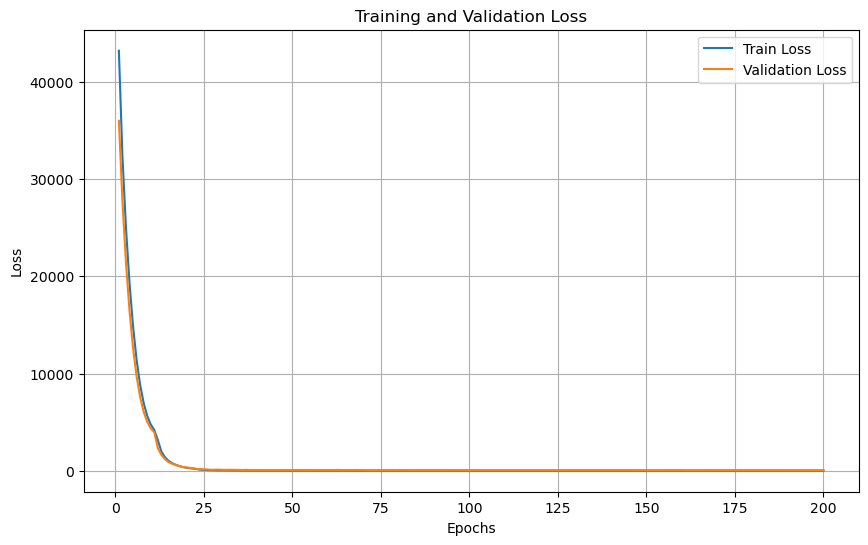

Train ended.


In [8]:
#model = BiLSTMRegressor(input_size=input_size,hidden_size= hidden_size, num_layers = num_layers, output_size = output_size).to(device)
#model = GRURegressor(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).to(device)
model = LSTMRegressor(input_size=input_size,hidden_size= hidden_size, num_layers = num_layers, output_size = output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=200)

print("Train ended.")


In [11]:
save_path = "./model_weights/regressor_T1.pth"


torch.save(model.state_dict(), save_path)
print(f"✅ 모델이 저장되었습니다: {save_path}")


✅ 모델이 저장되었습니다: ./model_weights/regressor_T1.pth


Evaluation Metrics:
RMSE: 20.0382
MAE: 17.3423
R² Score: 0.8734
MAPE: 9.67%
Explained Variance Score: 0.9080


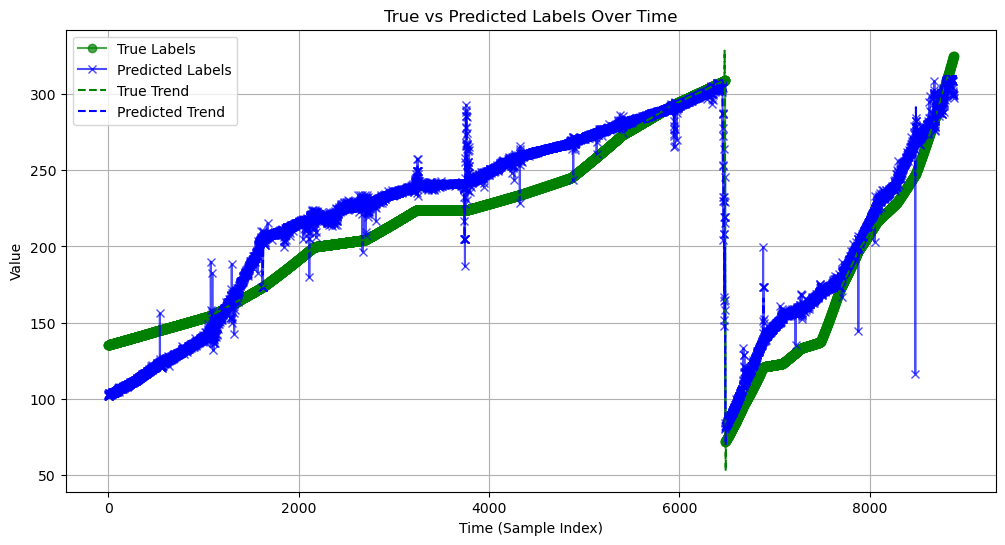

Test Metrics:
RMSE: 20.0382
MAE: 17.3423
R² Score: 0.8734
MAPE: 9.67%
Explained Variance Score: 0.9080


In [9]:
# Evaluate the model and visualize
metrics, all_preds, all_labels = evaluate_model(model, test_loader, device) #T5 검증용

print(f"Test Metrics:")
print(f"RMSE: {metrics['RMSE']:.4f}")
print(f"MAE: {metrics['MAE']:.4f}")
print(f"R² Score: {metrics['R2 Score']:.4f}")
print(f"MAPE: {metrics['MAPE']:.2f}%")
print(f"Explained Variance Score: {metrics['Explained Variance Score']:.4f}")

In [13]:
# when you just want to load saved model
regressor = LSTMRegressor(input_size=input_size,hidden_size= hidden_size, num_layers = num_layers, output_size = output_size).to(device)
save_path = "./model_weights/regressor_T1.pth"

regressor.load_state_dict(torch.load(save_path))
regressor.eval()  # 평가 모드로 설정
print("✅ 저장된 모델을 불러왔습니다.")


✅ 저장된 모델을 불러왔습니다.


In [14]:
train_loader_real = create_loaders(
    directories=train_dirs,  
    mode=mode,
    batch_size=batch_size,
    train_val_ratio=None  
) # for learning mlp layer using T1

Evaluation Metrics:
RMSE: 2.9799
MAE: 0.8647
R² Score: 0.9975
MAPE: 0.43%
Explained Variance Score: 0.9975


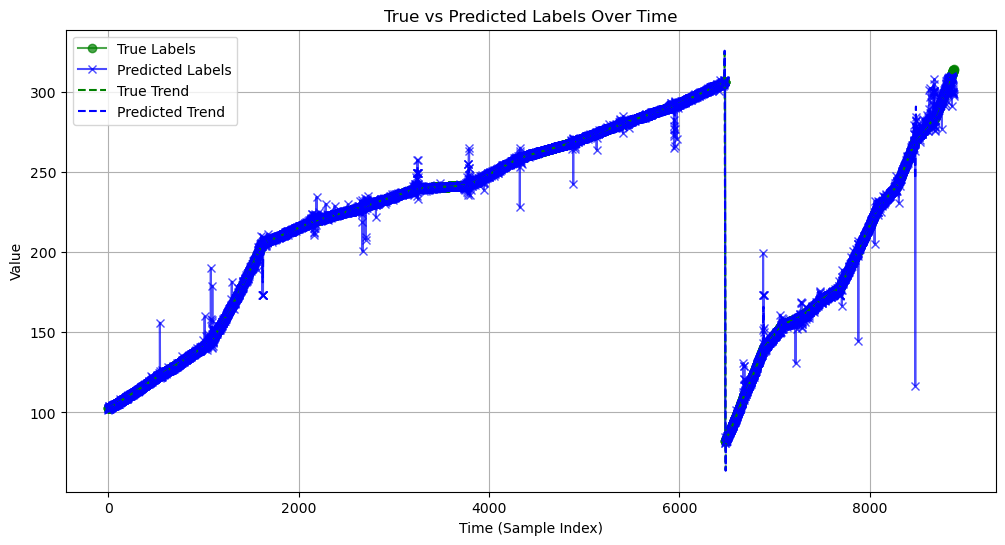

Test Metrics:
RMSE: 2.9799
MAE: 0.8647
R² Score: 0.9975
MAPE: 0.43%
Explained Variance Score: 0.9975


In [16]:
# use this predictions for learning mlp layer
metrics, all_preds, all_labels = evaluate_model(regressor, train_loader_real, device)

print(f"Test Metrics:")
print(f"RMSE: {metrics['RMSE']:.4f}")
print(f"MAE: {metrics['MAE']:.4f}")
print(f"R² Score: {metrics['R2 Score']:.4f}")
print(f"MAPE: {metrics['MAPE']:.2f}%")
print(f"Explained Variance Score: {metrics['Explained Variance Score']:.4f}")

In [17]:
print(len(all_preds))

8880


In [18]:
import pandas as pd


df_regression_predictions = pd.DataFrame({
    "Regression_Output": all_preds[:6480],  # predicted value of T1
    "True_Labels": all_labels[:6480]        # True label of T1
})

# CSV 파일로 저장
df_regression_predictions.to_csv("regressiontrainset_for_mlp.csv", index=False)

print("Regression Predictions saved as 'regressiontrainset_for_mlp.csv'.")


Regression Predictions saved as 'regressiontrainset_for_mlp.csv'.


### False alarm Scenario (w/o multimodal)

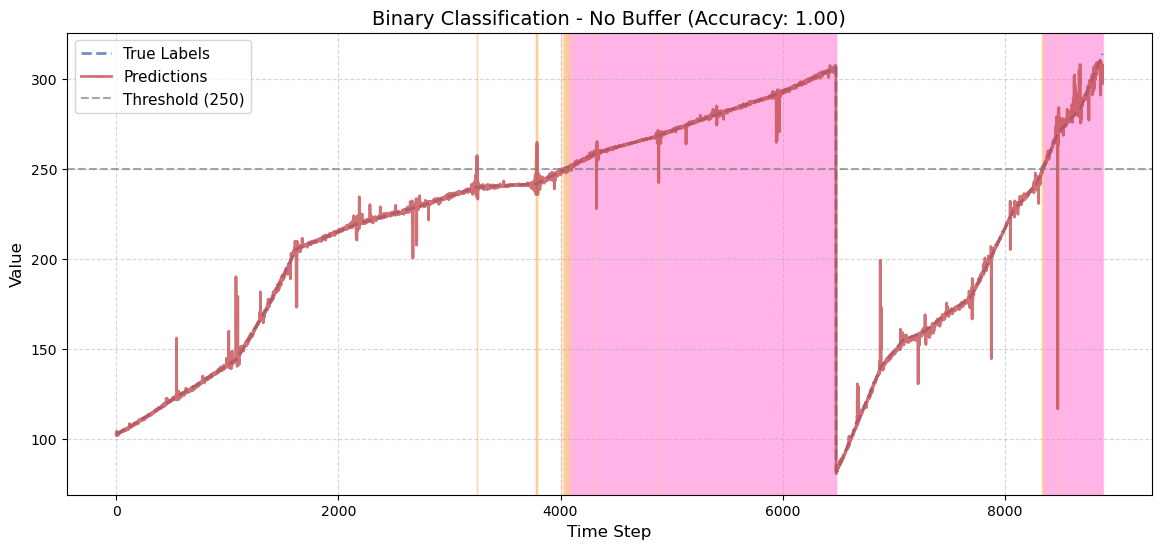

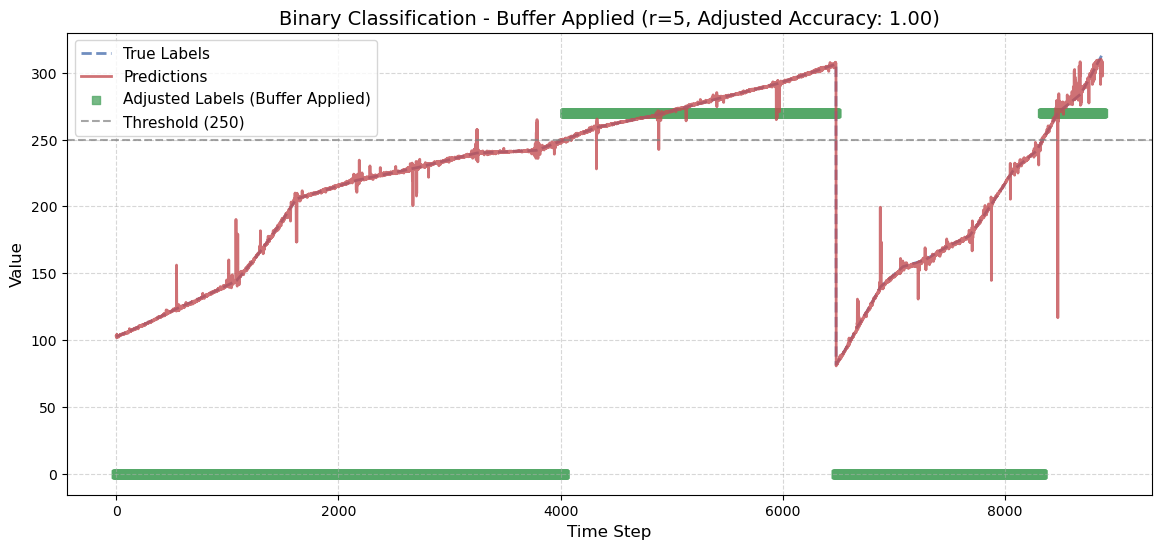

In [20]:
import numpy as np
import matplotlib.pyplot as plt


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
time_steps = len(all_preds)  


binary_preds = (all_preds > 250).astype(int)
binary_labels = (all_labels > 250).astype(int)
accuracy = np.mean(binary_preds == binary_labels)


r = 5  
adjusted_labels = np.copy(binary_labels)


for i in range(1, time_steps):
    if all_labels[i] > 250:
        adjusted_labels[max(0, i - r):i] = 1  

adjusted_accuracy = np.mean(binary_preds == adjusted_labels)


plt.figure(figsize=(14, 6))
plt.plot(all_labels, label="True Labels", color="#4c72b0", linewidth=2, linestyle="dashed", alpha=0.8)
plt.plot(all_preds, label="Predictions", color="#c44e52", linewidth=2, linestyle="solid", alpha=0.8)


for i in range(time_steps):
    if all_labels[i] > 250: #as domain knowledge
        plt.axvspan(i - 0.5, i + 0.5, color="#ffb3e6", alpha=0.4)  

# False Prediction 
false_preds = np.where(binary_preds != binary_labels)[0]
for i in false_preds:
    plt.axvspan(i - 0.5, i + 0.5, color="#ffcc99", alpha=0.6) 

# Threshold line
plt.axhline(y=250, color="gray", linestyle="--", linewidth=1.5, alpha=0.7, label="Threshold (250)")


plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title(f"Binary Classification - No Buffer (Accuracy: {accuracy:.2f})", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(all_labels, label="True Labels", color="#4c72b0", linewidth=2, linestyle="dashed", alpha=0.8)
plt.plot(all_preds, label="Predictions", color="#c44e52", linewidth=2, linestyle="solid", alpha=0.8)

plt.scatter(range(time_steps), adjusted_labels * 270, color="#55a868", marker="s", alpha=0.8, label="Adjusted Labels (Buffer Applied)")

plt.axhline(y=250, color="gray", linestyle="--", linewidth=1.5, alpha=0.7, label="Threshold (250)")

plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title(f"Binary Classification - Buffer Applied (r={r}, Adjusted Accuracy: {adjusted_accuracy:.2f})", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


### Classifier Train

In [10]:
from model import CNNClassifier, EfficientNetBinary, MobileNetBinary, ResNetClassifier
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
from utils import MelSpectrogramDataset, evaluate_model, train_model, plot_loss_curve

batch_size = 128
num_epochs = 20
learning_rate = 0.001
train_anomaly_threshold = 4041  # T1's index 
test_anomaly_threshold = 4961  # T5's index

train_data_dir_acus= "/home/crois-times/timeseries/JJ/Harvard_Multimodal/Mel_spectrogram/T1"  # T1: Train + Val

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = CNNClassifier().to(device)
#eff = EfficientNetBinary(pretrained=True).to(device)
# mob = MobileNetBinary(pretrained=False).to(device)
# res = ResNetClassifier(pretrained=False).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [22]:

from utils import evaluate_model, train_model, plot_loss_curve

train_dataset = MelSpectrogramDataset(
    data_dir=train_data_dir_acus,
    anomaly_threshold=4041
)

# Train/Validation Split (80% Train, 20% Val)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



In [23]:
train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs) #batch size에 매우 민감


✅ Saved best model (Val Loss: 0.5802)
[1/20] Train Loss: 0.7483, Acc: 0.6069 | Val Loss: 0.5802, Acc: 0.7114


✅ Saved best model (Val Loss: 0.5352)
[2/20] Train Loss: 0.5571, Acc: 0.7054 | Val Loss: 0.5352, Acc: 0.7369


✅ Saved best model (Val Loss: 0.5006)
[3/20] Train Loss: 0.5146, Acc: 0.7303 | Val Loss: 0.5006, Acc: 0.7431


✅ Saved best model (Val Loss: 0.3965)
[4/20] Train Loss: 0.4566, Acc: 0.7787 | Val Loss: 0.3965, Acc: 0.7955


✅ Saved best model (Val Loss: 0.3165)
[5/20] Train Loss: 0.3395, Acc: 0.8573 | Val Loss: 0.3165, Acc: 0.8418


✅ Saved best model (Val Loss: 0.2000)
[6/20] Train Loss: 0.2173, Acc: 0.9163 | Val Loss: 0.2000, Acc: 0.9252


✅ Saved best model (Val Loss: 0.1450)
[7/20] Train Loss: 0.1466, Acc: 0.9454 | Val Loss: 0.1450, Acc: 0.9421


[8/20] Train Loss: 0.1006, Acc: 0.9657 | Val Loss: 0.1462, Acc: 0.9390


✅ Saved best model (Val Loss: 0.0692)
[9/20] Train Loss: 0.0729, Acc: 0.9780 | Val Loss: 0.0692, Acc: 0.9761


[10/20] Train Loss: 0.0487, Acc: 0.9898 | Val Loss: 0.0768, Acc: 0.9691


✅ Saved best model (Val Loss: 0.0402)
[11/20] Train Loss: 0.0356, Acc: 0.9919 | Val Loss: 0.0402, Acc: 0.9869


[12/20] Train Loss: 0.0276, Acc: 0.9938 | Val Loss: 0.0684, Acc: 0.9707


✅ Saved best model (Val Loss: 0.0317)
[13/20] Train Loss: 0.0276, Acc: 0.9913 | Val Loss: 0.0317, Acc: 0.9892


✅ Saved best model (Val Loss: 0.0227)
[14/20] Train Loss: 0.0180, Acc: 0.9965 | Val Loss: 0.0227, Acc: 0.9954


[15/20] Train Loss: 0.0179, Acc: 0.9959 | Val Loss: 0.0258, Acc: 0.9946


✅ Saved best model (Val Loss: 0.0166)
[16/20] Train Loss: 0.0100, Acc: 0.9992 | Val Loss: 0.0166, Acc: 0.9969


[17/20] Train Loss: 0.0058, Acc: 0.9998 | Val Loss: 0.0170, Acc: 0.9946


✅ Saved best model (Val Loss: 0.0154)
[18/20] Train Loss: 0.0052, Acc: 0.9998 | Val Loss: 0.0154, Acc: 0.9969


✅ Saved best model (Val Loss: 0.0144)
[19/20] Train Loss: 0.0038, Acc: 1.0000 | Val Loss: 0.0144, Acc: 0.9961


✅ Saved best model (Val Loss: 0.0121)
[20/20] Train Loss: 0.0037, Acc: 1.0000 | Val Loss: 0.0121, Acc: 0.9969


In [24]:
# 저장할 경로
save_path = "./model_weights/classifier_T1.pth"

# 모델 저장
torch.save(model.state_dict(), save_path)
print(f"✅ 모델이 저장되었습니다: {save_path}")


✅ 모델이 저장되었습니다: ./model_weights/classifier_T1.pth


In [6]:
# when you just want to load saved model
classifier = CNNClassifier().to(device)
save_path = "./model_weights/classifier_T1.pth"

classifier.load_state_dict(torch.load(save_path))
classifier.eval()  # 평가 모드로 설정
print("✅ 저장된 모델을 불러왔습니다.")


✅ 저장된 모델을 불러왔습니다.


### Classifier Inference

In [7]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
from utils import MelSpectrogramDataset, evaluate_model, train_model, plot_loss_curve
from utils import evaluate_test


test_data_dir_acus = "/home/crois-times/timeseries/JJ/Harvard_Multimodal/Mel_spectrogram/T5"  # T5: Test
test_dataset = MelSpectrogramDataset(test_data_dir_acus, anomaly_threshold = 4961)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)  

In [11]:
train = MelSpectrogramDataset(train_data_dir_acus, anomaly_threshold = 4041)
train_loader = DataLoader(train, batch_size=128, shuffle=False)  
train_predictions = evaluate_test(classifier, train_loader)


Test Accuracy: 0.9994


In [22]:
train_predictions # for training mlp layers

[(0, 0.500996),
 (0, 0.5009697),
 (0, 0.50053275),
 (0, 0.500124),
 (0, 0.50160766),
 (0, 0.5009793),
 (0, 0.5002574),
 (0, 0.5001982),
 (0, 0.5004637),
 (0, 0.5001299),
 (0, 0.5000367),
 (0, 0.50002664),
 (0, 0.5006709),
 (0, 0.50020325),
 (0, 0.50013053),
 (0, 0.5000289),
 (0, 0.5001849),
 (0, 0.5003027),
 (0, 0.5000435),
 (0, 0.50023264),
 (0, 0.50041145),
 (0, 0.5017908),
 (0, 0.5002103),
 (0, 0.50004333),
 (0, 0.50010484),
 (0, 0.5000371),
 (0, 0.50006163),
 (0, 0.5000157),
 (0, 0.5000104),
 (0, 0.5000412),
 (0, 0.5002562),
 (0, 0.50008374),
 (0, 0.5000631),
 (0, 0.5001771),
 (0, 0.5003182),
 (0, 0.5000123),
 (0, 0.50007915),
 (0, 0.50016767),
 (0, 0.5005608),
 (0, 0.5000841),
 (0, 0.5000034),
 (0, 0.5000578),
 (0, 0.5000298),
 (0, 0.50009096),
 (0, 0.5000555),
 (0, 0.5001468),
 (0, 0.5003095),
 (0, 0.50015444),
 (0, 0.5006685),
 (0, 0.5003707),
 (0, 0.50199366),
 (0, 0.5010498),
 (0, 0.50014603),
 (0, 0.5000972),
 (0, 0.5005488),
 (0, 0.5000965),
 (0, 0.500175),
 (0, 0.5000208),


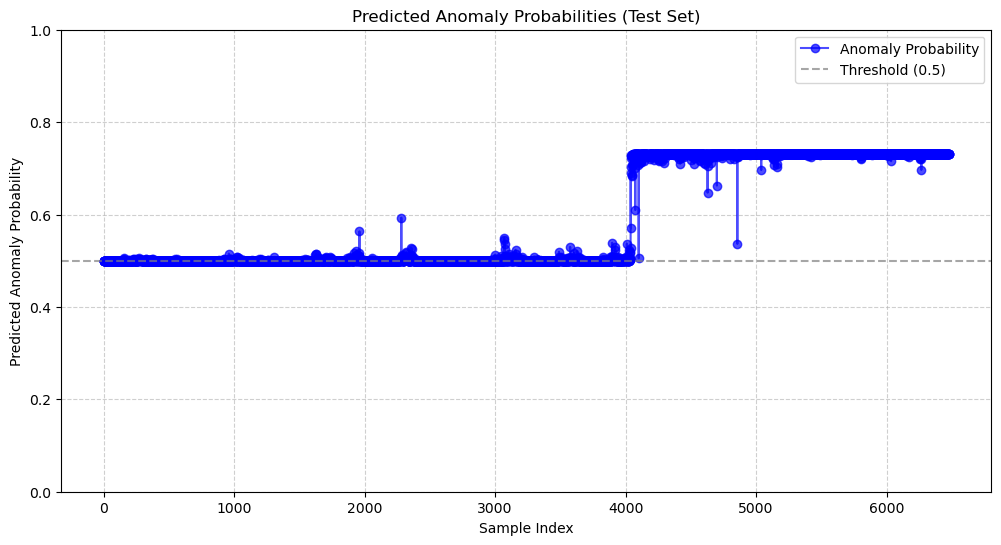

In [12]:
import matplotlib.pyplot as plt

def plot_anomaly_probabilities(predictions):
    # ✅ 예측 확률만 추출 (Anomaly 확률)
    anomaly_probs = [prob for _, prob in predictions]

    # ✅ 시각화 (선 그래프)
    plt.figure(figsize=(12, 6))
    plt.plot(anomaly_probs, marker="o", linestyle="-", color="blue", alpha=0.7, label="Anomaly Probability")
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label="Threshold (0.5)")  # 기준선 추가
    plt.xlabel("Sample Index")
    plt.ylabel("Predicted Anomaly Probability")
    plt.title("Predicted Anomaly Probabilities (Test Set)")
    plt.ylim(0, 1)  # 확률 범위 고정 (0~1)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# ✅ 예측된 확률값을 시각화
plot_anomaly_probabilities(train_predictions)


In [13]:
import pandas as pd

# ✅ CNN 예측 확률값을 저장할 DataFrame 생성
df_cnn_predictions = pd.DataFrame({
    "Anomaly_Probability": [prob for _, prob in train_predictions]
})

# ✅ CSV 파일로 저장
df_cnn_predictions.to_csv("classifiertrainset_for_mlp.csv", index=False)

print("CNN Predictions saved as 'classifiertrainset_for_mlp.csv'.")


CNN Predictions saved as 'classifiertrainset_for_mlp.csv'.


### Multimodal-inference(stacking layer)

In [16]:
lstm_predictions = pd.read_csv('regressiontrainset_for_mlp.csv')

In [14]:
cnn_predictions = pd.read_csv('classifiertrainset_for_mlp.csv')

In [17]:
cnn_predictions

,Anomaly_Probability
0,0.500000
1,0.500001
2,0.500000
3,0.500000
4,0.500077
...,...
6475,0.731038
6476,0.730944
6477,0.731029
6478,0.730324


In [18]:
lstm_predictions

,Regression_Output,True_Labels
0,102.716866,102.472000
1,102.356050,102.507324
2,102.947420,102.542660
3,101.816890,102.578010
4,103.386116,102.613370
...,...,...
6475,307.310060,306.336120
6476,307.858150,306.364600
6477,306.826350,306.393070
6478,307.160830,306.421540


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from model import MLPStacking, RUL_MLP


# Stacking을 위한 Feature 생성 (GRU 예측값 앞 6480개만 사용)
X_meta = np.column_stack((lstm_predictions["Regression_Output"], cnn_predictions["Anomaly_Probability"]))  # (LSTM Prediction, CNN probabilities)
y_meta = np.array([1 if i >= 4961 else 0 for i in range(6480)])  # Ground Truth for T5

#PyTorch Tensor 변환
X_meta_tensor = torch.tensor(X_meta, dtype=torch.float32)
y_meta_tensor = torch.tensor(y_meta, dtype=torch.float32).unsqueeze(1)  # (batch_size, 1) 형태로 변환


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_meta.shape[1]  # Feature 개수 (2개: GRU + CNN)
mlp_model = MLPStacking(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)


X_meta_tensor, y_meta_tensor = X_meta_tensor.to(device), y_meta_tensor.to(device)


num_epochs = 20000
for epoch in range(num_epochs):
    mlp_model.train()
    optimizer.zero_grad()
    
    outputs = mlp_model(X_meta_tensor)
    loss = criterion(outputs, y_meta_tensor)
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


mlp_model.eval()
with torch.no_grad():
    final_predictions = (mlp_model(X_meta_tensor) > 0.5).cpu().numpy().astype(int)

final_accuracy = accuracy_score(y_meta, final_predictions)
print(f"Final Stacked Model Accuracy (MLP): {final_accuracy:.4f}")


Epoch [10/20000], Loss: 0.6480
Epoch [20/20000], Loss: 0.6401
Epoch [30/20000], Loss: 0.6403
Epoch [40/20000], Loss: 0.6243
Epoch [50/20000], Loss: 0.6199
Epoch [60/20000], Loss: 0.6187
Epoch [70/20000], Loss: 0.6175
Epoch [80/20000], Loss: 0.6163
Epoch [90/20000], Loss: 0.6150
Epoch [100/20000], Loss: 0.6137
Epoch [110/20000], Loss: 0.6123
Epoch [120/20000], Loss: 0.6109
Epoch [130/20000], Loss: 0.6094
Epoch [140/20000], Loss: 0.6079
Epoch [150/20000], Loss: 0.6063
Epoch [160/20000], Loss: 0.6047
Epoch [170/20000], Loss: 0.6031
Epoch [180/20000], Loss: 0.6014
Epoch [190/20000], Loss: 0.5996
Epoch [200/20000], Loss: 0.5978
Epoch [210/20000], Loss: 0.5959
Epoch [220/20000], Loss: 0.5940
Epoch [230/20000], Loss: 0.5920
Epoch [240/20000], Loss: 0.5900
Epoch [250/20000], Loss: 0.5878
Epoch [260/20000], Loss: 0.5856
Epoch [270/20000], Loss: 0.5833
Epoch [280/20000], Loss: 0.5809
Epoch [290/20000], Loss: 0.5785
Epoch [300/20000], Loss: 0.5759
Epoch [310/20000], Loss: 0.5732
Epoch [320/20000]

In [20]:

torch.save(mlp_model.state_dict(), "model_weights/mlp_binaryprediction.pth")


In [21]:

mlp_model = MLPStacking(input_dim=input_dim).to(device)
mlp_model.load_state_dict(torch.load("model_weights/mlp_binaryprediction.pth", map_location=device))
mlp_model.eval()

MLPStacking(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [24]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# === T5 TEST용 CSV 불러오기 ===
df_cnn_test = pd.read_csv("cnn_predictions.csv")  # CNN 확률
df_gru_test = pd.read_csv("regression_predictions_lstm_T5.csv")  # GRU 예측값

# === Feature 생성 (CNN 확률 + GRU 회귀 예측값)
X_test = np.column_stack((df_gru_test["Regression_Output"][:6480], df_cnn_test["Anomaly_Probability"]))

# === Ground Truth 라벨 생성 (예시: T5에서 4961 이후는 이상이라고 가정)
y_test = np.array([1 if i >= 4961 else 0 for i in range(len(X_test))])

# === Tensor로 변환
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# === MLP 모델 평가
mlp_model.eval()
with torch.no_grad():
    y_pred_prob = mlp_model(X_test_tensor).cpu().numpy()
    y_pred_cls = (y_pred_prob > 0.5).astype(int)

# === 지표 출력
print("Test 성능 평가")
print(f"Accuracy : {accuracy_score(y_test, y_pred_cls):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_cls):.4f}")
print(f"AUROC    : {roc_auc_score(y_test, y_pred_prob):.4f}")


Test 성능 평가
Accuracy : 0.9861
F1 Score : 0.9700
AUROC    : 0.9935


### RUL Prediction

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

y_rul = np.array([max(0, (4960 - i) * 0.1) for i in range(6480)])  # Train RUL MLP


X_tensor = torch.tensor(X_meta, dtype=torch.float32)
y_tensor = torch.tensor(y_rul, dtype=torch.float32).unsqueeze(1)  # (batch_size, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_meta.shape[1]
model = RUL_MLP(input_dim).to(device)
criterion = nn.MSELoss()  # 회귀니까 MSE!
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_tensor, y_tensor = X_tensor.to(device), y_tensor.to(device)

num_epochs = 20000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    preds = model(X_tensor)
    loss = criterion(preds, y_tensor)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f"[{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    predictions = model(X_tensor).cpu().numpy().flatten()


for i, p in enumerate(predictions[:10]):
    print(f" for timestep {i+1}: Remaining Useful Time: {p:.1f} sec")


[500/20000] Loss: 41406.9688
[1000/20000] Loss: 41103.2812
[1500/20000] Loss: 38545.7031
[2000/20000] Loss: 7704.5078
[2500/20000] Loss: 3567.0242
[3000/20000] Loss: 1568.0529
[3500/20000] Loss: 630.3590
[4000/20000] Loss: 303.8835
[4500/20000] Loss: 203.3003
[5000/20000] Loss: 157.5264
[5500/20000] Loss: 149.7225
[6000/20000] Loss: 140.8194
[6500/20000] Loss: 139.0800
[7000/20000] Loss: 139.3308
[7500/20000] Loss: 140.5291
[8000/20000] Loss: 137.5091
[8500/20000] Loss: 138.0945
[9000/20000] Loss: 133.7985
[9500/20000] Loss: 136.7125
[10000/20000] Loss: 133.4138
[10500/20000] Loss: 138.5405
[11000/20000] Loss: 129.4930
[11500/20000] Loss: 128.8586
[12000/20000] Loss: 127.9229
[12500/20000] Loss: 126.4865
[13000/20000] Loss: 125.5082
[13500/20000] Loss: 128.4566
[14000/20000] Loss: 124.3084
[14500/20000] Loss: 126.9921
[15000/20000] Loss: 122.4780
[15500/20000] Loss: 135.2863
[16000/20000] Loss: 123.2506
[16500/20000] Loss: 122.6052
[17000/20000] Loss: 120.7286
[17500/20000] Loss: 124.7

In [23]:

torch.save(model.state_dict(), "model_weights/rul_mlp_model.pth")


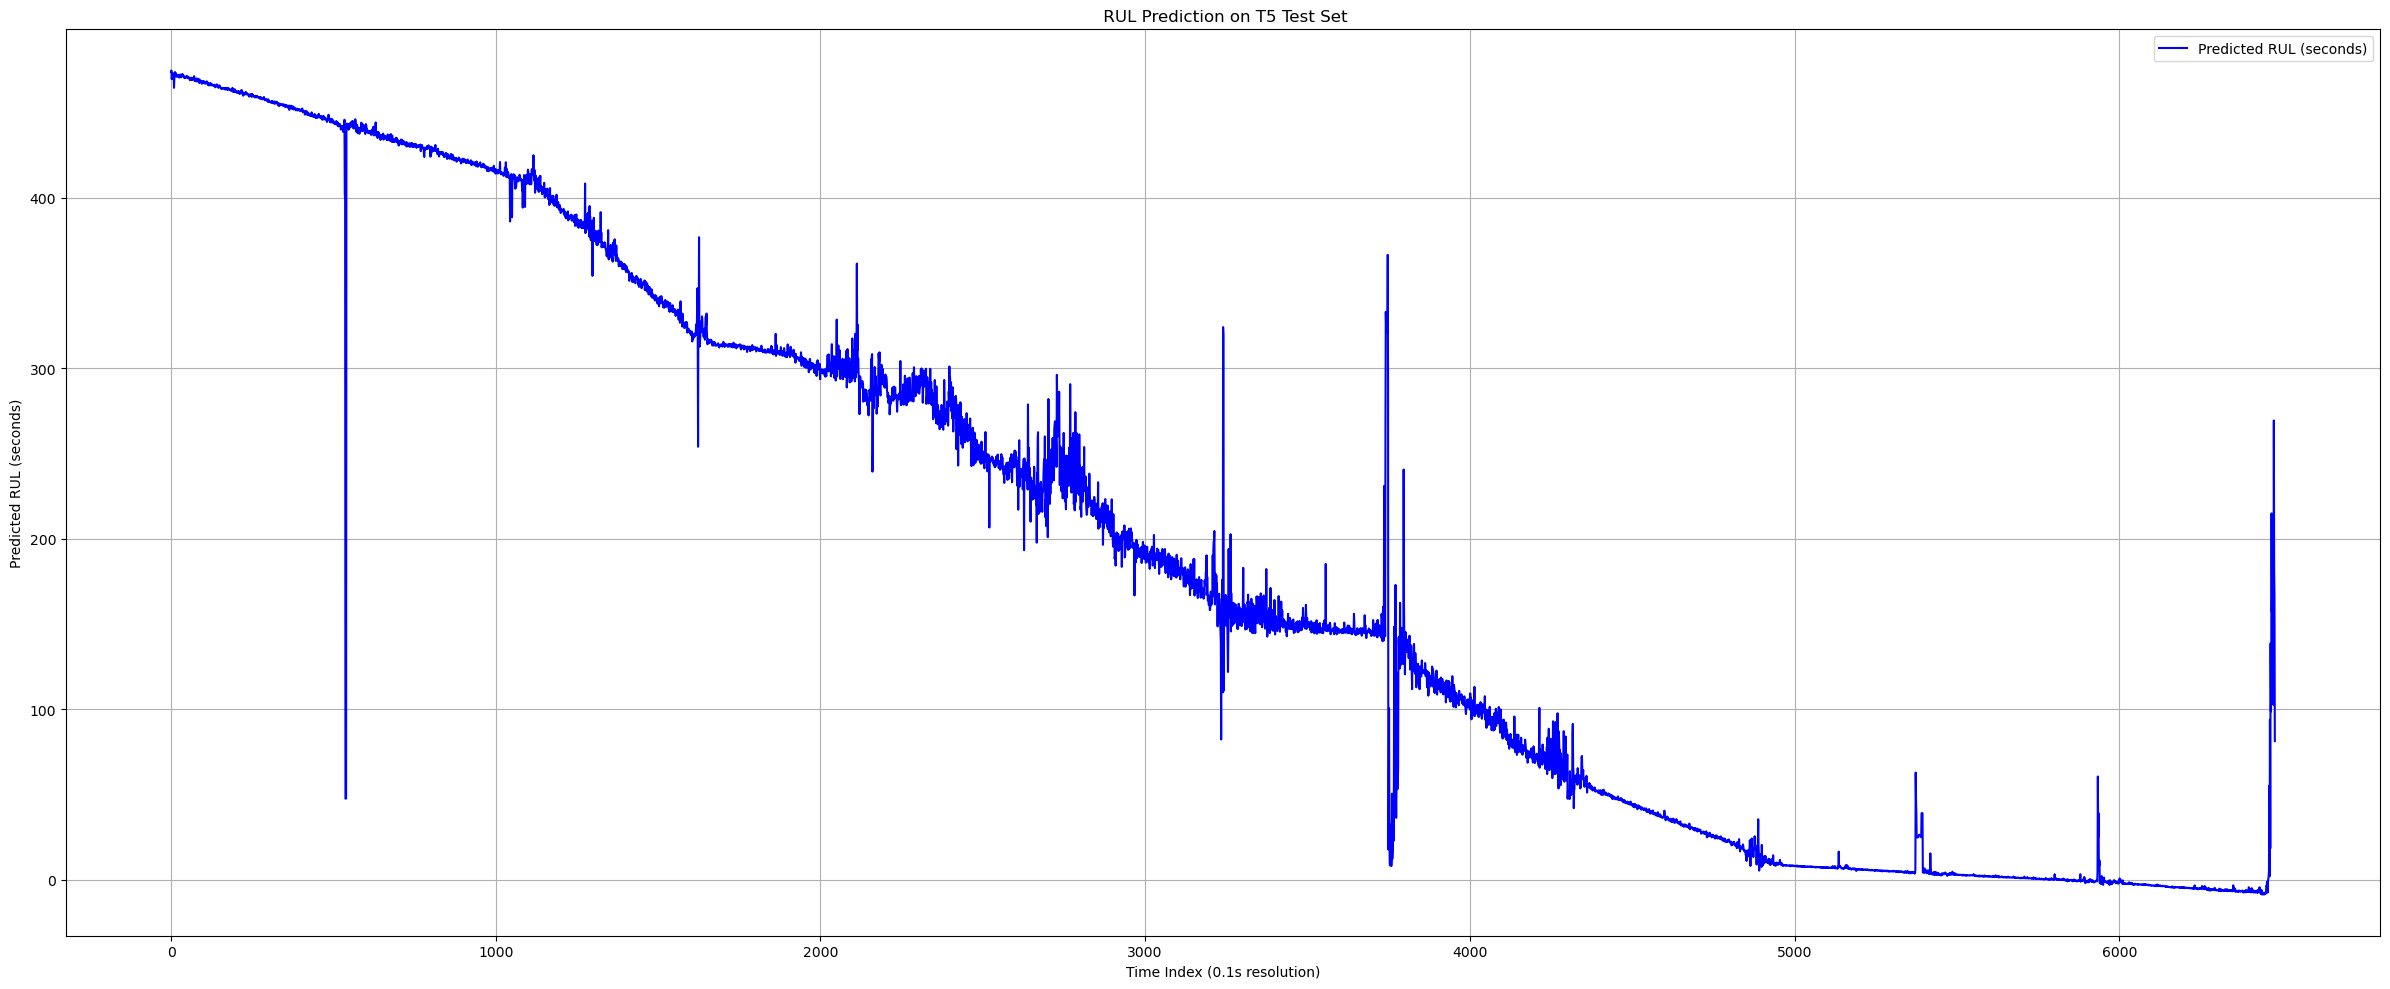


🔍 샘플별 예측 RUL (앞 20개):
Sample 1: ⏳ Predicted RUL = 473.9 seconds
Sample 2: ⏳ Predicted RUL = 474.6 seconds
Sample 3: ⏳ Predicted RUL = 469.7 seconds
Sample 4: ⏳ Predicted RUL = 471.3 seconds
Sample 5: ⏳ Predicted RUL = 469.9 seconds
Sample 6: ⏳ Predicted RUL = 472.9 seconds
Sample 7: ⏳ Predicted RUL = 472.5 seconds
Sample 8: ⏳ Predicted RUL = 472.7 seconds
Sample 9: ⏳ Predicted RUL = 472.9 seconds
Sample 10: ⏳ Predicted RUL = 464.5 seconds
Sample 11: ⏳ Predicted RUL = 470.1 seconds
Sample 12: ⏳ Predicted RUL = 471.0 seconds
Sample 13: ⏳ Predicted RUL = 473.7 seconds
Sample 14: ⏳ Predicted RUL = 472.9 seconds
Sample 15: ⏳ Predicted RUL = 472.5 seconds
Sample 16: ⏳ Predicted RUL = 473.0 seconds
Sample 17: ⏳ Predicted RUL = 472.1 seconds
Sample 18: ⏳ Predicted RUL = 471.1 seconds
Sample 19: ⏳ Predicted RUL = 470.9 seconds
Sample 20: ⏳ Predicted RUL = 472.0 seconds


In [25]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

# === ✅ T5 TEST 데이터 불러오기 ===
df_cnn_test = pd.read_csv("cnn_predictions.csv")  # CNN 확률
df_gru_test = pd.read_csv("regression_predictions_lstm_T5.csv")  # GRU 예측값

# === ✅ Feature 구성 ===
X_test = np.column_stack((df_gru_test["Regression_Output"][:6480], df_cnn_test["Anomaly_Probability"]))

# === ✅ Tensor 변환
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# === ✅ 학습된 모델 불러오기
model = RUL_MLP(input_dim=2).to(device)
model.load_state_dict(torch.load("model_weights/rul_mlp_model.pth"))
model.eval()

# === ✅ 예측
with torch.no_grad():
    rul_predictions = model(X_test_tensor).cpu().numpy().flatten()

# === ✅ 시각화
plt.figure(figsize=(24, 10))
plt.plot(rul_predictions, label='Predicted RUL (seconds)', color='blue')
plt.xlabel('Time Index (0.1s resolution)')
plt.ylabel('Predicted RUL (seconds)')
plt.title(' RUL Prediction on T5 Test Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === ✅ 예시 출력 (앞 10개만)
print("\n🔍 샘플별 예측 RUL (앞 20개):")
for i, p in enumerate(rul_predictions[:20]):
    print(f"Sample {i+1}: ⏳ Predicted RUL = {p:.1f} seconds")


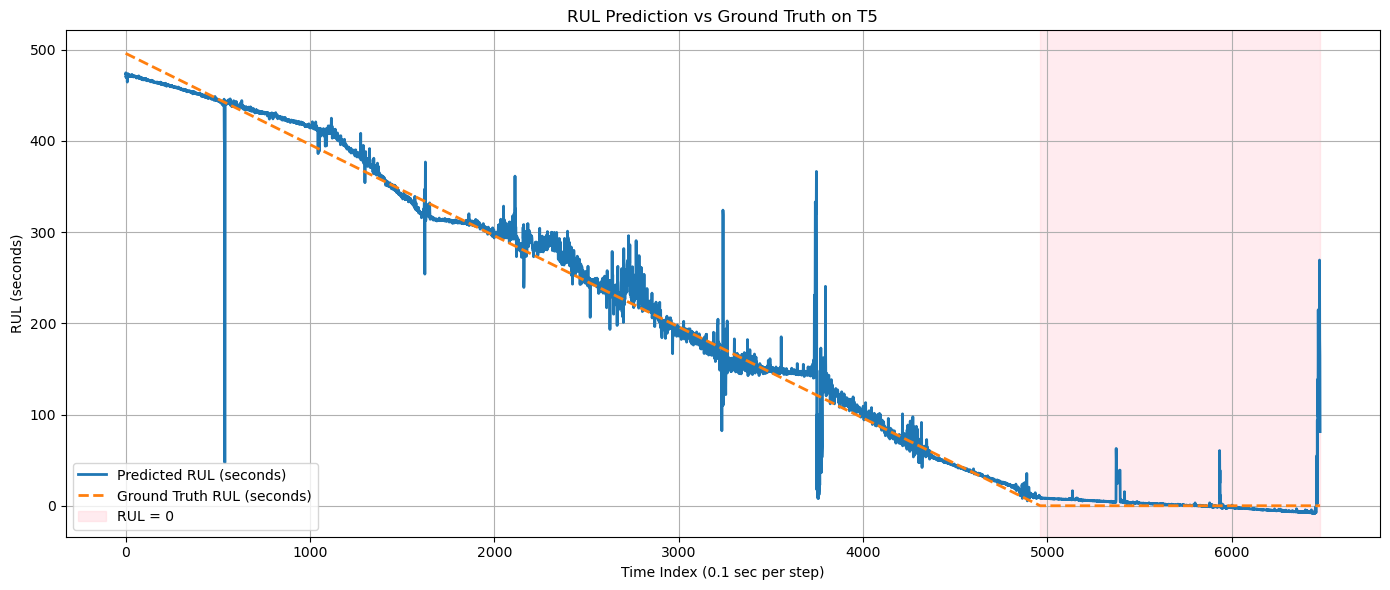

In [26]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

# === ✅ T5 TEST 데이터 불러오기
df_cnn_test = pd.read_csv("cnn_predictions.csv")  # CNN 확률
df_gru_test = pd.read_csv("regression_predictions_lstm_T5.csv")  # GRU 예측값

# === ✅ Feature 구성
X_test = np.column_stack((df_gru_test["Regression_Output"][:6480], df_cnn_test["Anomaly_Probability"]))
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# === ✅ Ground Truth RUL (초 단위)
rul_gt = np.array([max(0, (4960 - i) * 0.1) for i in range(6480)])


# === ✅ 예측
with torch.no_grad():
    rul_pred = model(X_test_tensor).cpu().numpy().flatten()

# === ✅ 시각화
plt.figure(figsize=(14, 6))
plt.plot(rul_pred, label='Predicted RUL (seconds)', linewidth=2)
plt.plot(rul_gt, label='Ground Truth RUL (seconds)', linewidth=2, linestyle='--')

# 🔴 수명 종료 이후 영역 (분홍색 음영)
plt.axvspan(4960, 6480, color='pink', alpha=0.3, label='RUL = 0 ')

plt.xlabel('Time Index (0.1 sec per step)')
plt.ylabel('RUL (seconds)')
plt.title('RUL Prediction vs Ground Truth on T5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ T5 Test Set 성능 평가
Accuracy : 0.9861
F1 Score : 0.9700
AUROC    : 0.9935


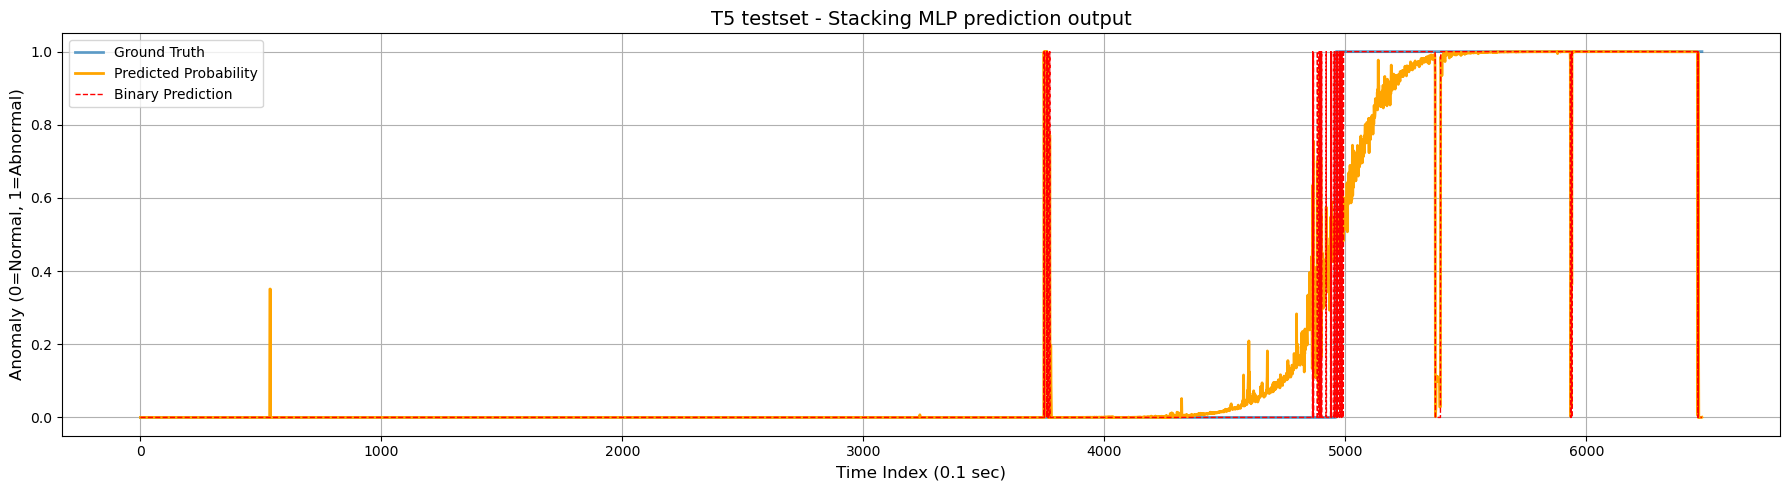

In [27]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# === ✅ T5 TEST CSV 불러오기 ===
df_cnn_test = pd.read_csv("cnn_predictions.csv")  # CNN 확률
df_gru_test = pd.read_csv("regression_predictions_lstm_T5.csv")  # GRU 예측값

# === ✅ Feature 생성 (GRU + CNN)
X_test = np.column_stack((df_gru_test["Regression_Output"][:6480], df_cnn_test["Anomaly_Probability"]))
y_test = np.array([1 if i >= 4961 else 0 for i in range(len(X_test))])  # Ground Truth

# === ✅ Tensor 변환
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# === ✅ 모델 평가
mlp_model.eval()
with torch.no_grad():
    y_pred_prob = mlp_model(X_test_tensor).cpu().numpy().flatten()
    y_pred_cls = (y_pred_prob > 0.5).astype(int)

# === ✅ 성능 지표 출력
print("✅ T5 Test Set 성능 평가")
print(f"Accuracy : {accuracy_score(y_test, y_pred_cls):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_cls):.4f}")
print(f"AUROC    : {roc_auc_score(y_test, y_pred_prob):.4f}")

# === ✅ 그래프 시각화
plt.figure(figsize=(18, 5))
plt.plot(y_test, label="Ground Truth", linewidth=2, alpha=0.7)
plt.plot(y_pred_prob, label="Predicted Probability", color='orange', linewidth=2)
plt.plot(y_pred_cls, label="Binary Prediction", linestyle='--', color='red', linewidth=1)

plt.title("T5 testset - Stacking MLP prediction output", fontsize=14)
plt.xlabel("Time Index (0.1 sec)", fontsize=12)
plt.ylabel("Anomaly (0=Normal, 1=Abnormal)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



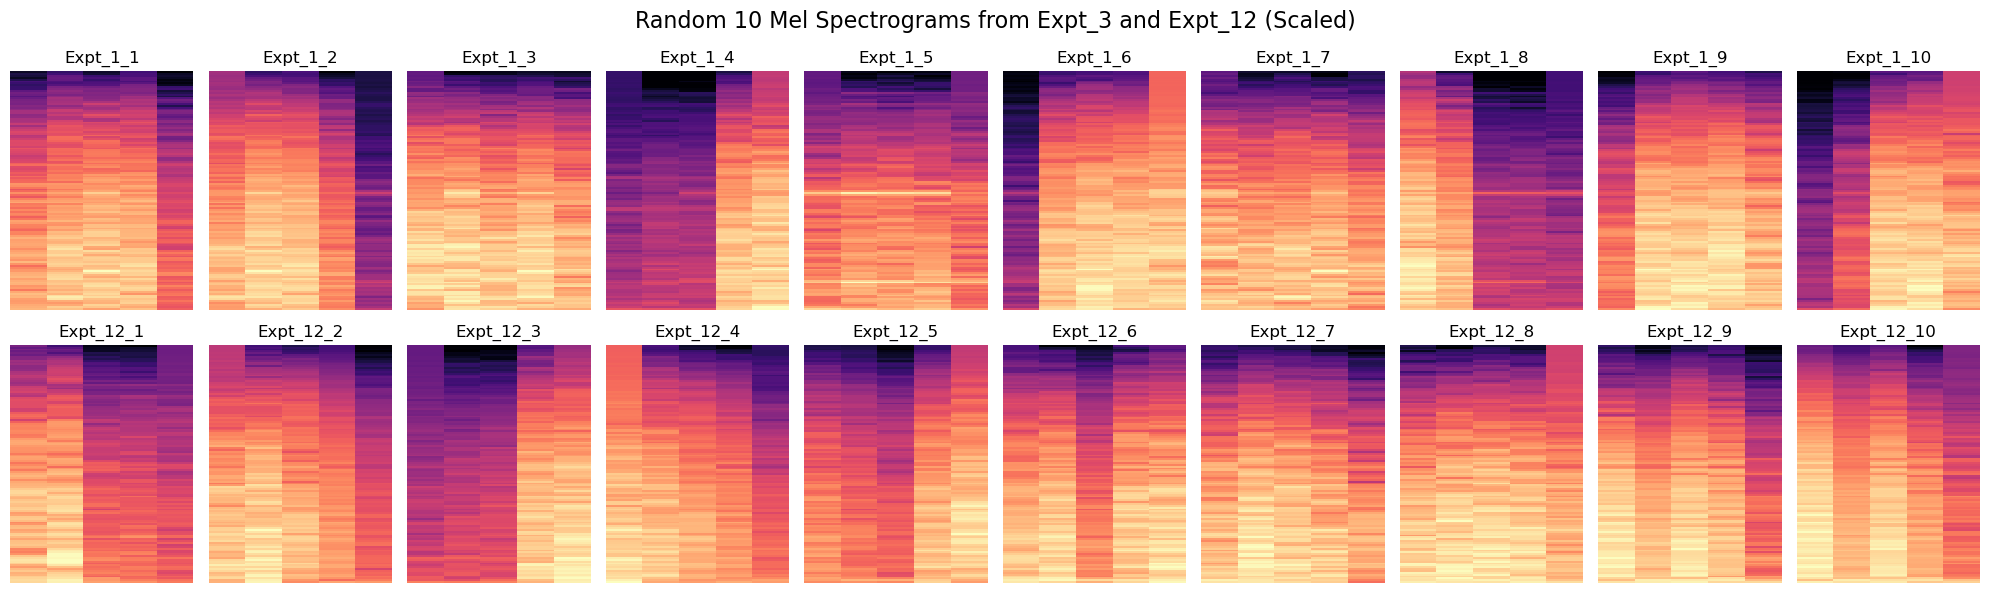

In [36]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random

# === ✅ 설정 ===
data_dir = "/home/crois-times/timeseries/projects/tool_wear_havard/data/dataverse_files/Dataset/T1/Acoustic_Emission_Data"
num_splits = 10  # 무작위로 10개만 생성하여 시각화
window_size = 1000  # STFT 윈도우 크기
desired_length = 2048  # 보간 후 신호 길이
sr = 1000  # 샘플링 레이트
n_fft = 1000  # FFT 크기
hop_length = 512  # STFT hop 크기
n_mels = 128  # Mel 필터 개수
fmax = 500  # 저주파 강조

# === ✅ Mel Spectrogram 변환 함수 ===
def generate_mel_spectrogram(signal, sr=1000, n_fft=1000, hop_length=512, n_mels=128, fmax=500):
    """Mel Spectrogram 변환 (저주파 강조)"""
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, 
                                              n_mels=n_mels, fmin=0, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.min)  # 약한 신호도 강조
    return mel_spec_db

# === ✅ Expt_3과 Expt_12에서 무작위 10개 생성 및 시각화 ===
fig, axes = plt.subplots(2, 10, figsize=(20, 6))

for row_idx, expt_idx in enumerate([1, 12]):  # Expt_3, Expt_12 처리
    file_path = os.path.join(data_dir, f"Expt_{expt_idx}.csv")
    
    # CSV 파일 읽기
    df = pd.read_csv(file_path)
    
    # 무작위 시작점 선택 (겹치지 않도록 설정)
    start_indices = random.sample(range(0, len(df) - window_size), num_splits)
    
    for col_idx, start in enumerate(start_indices):
        # 슬라이싱
        df_split = df.iloc[start : start + window_size].reset_index(drop=True)
        
        # 신호 데이터 (첫 번째 컬럼 사용)
        signal = df_split.iloc[:, 0].values
        
        # 보간 적용 (길이 맞추기)
        x_original = np.linspace(0, 1, len(signal))
        x_new = np.linspace(0, 1, desired_length)
        interpolator = interp1d(x_original, signal, kind='linear')
        signal_interpolated = interpolator(x_new)
        
        # === ✅ 방법 4 적용: 신호 크기 Scaling ===
        signal_scaled = signal_interpolated * np.mean(signal_interpolated)  # 크기에 비례한 Scaling
        
        # Mel Spectrogram 변환
        melspec_db = generate_mel_spectrogram(signal_scaled, sr, n_fft, hop_length, n_mels, fmax)
        
        # 시각화
        librosa.display.specshow(melspec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f"Expt_{expt_idx}_{col_idx+1}")
        axes[row_idx, col_idx].axis("off")

plt.suptitle("Random 10 Mel Spectrograms from Expt_3 and Expt_12 (Scaled)", fontsize=16)
plt.tight_layout()
plt.show()


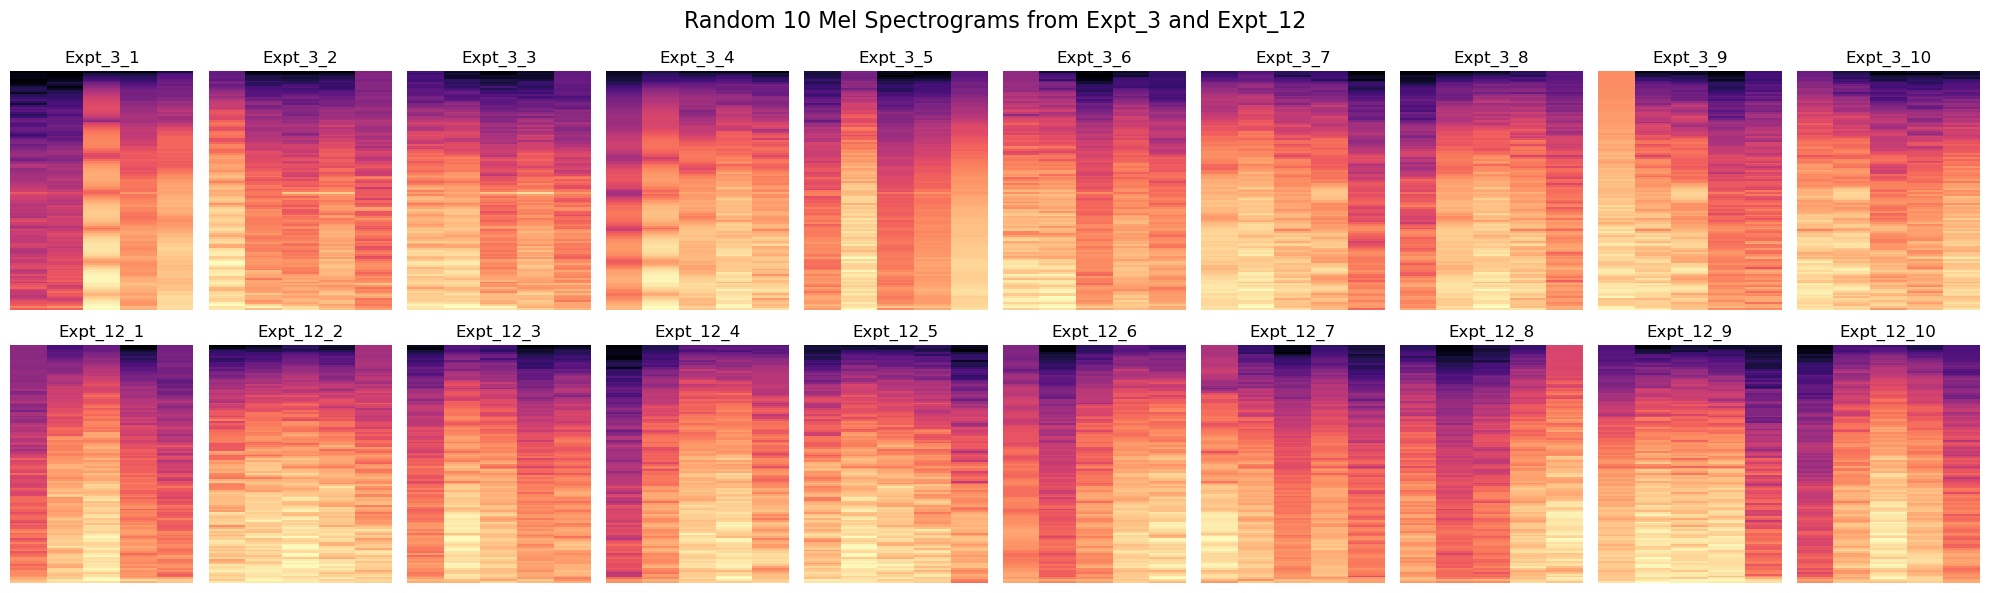

In [22]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random

# === ✅ 설정 ===
data_dir = "/home/crois-times/timeseries/projects/tool_wear_havard/data/dataverse_files/Dataset/T1/Acoustic_Emission_Data"
num_splits = 10  # 무작위로 10개만 생성하여 시각화
window_size = 1000  # STFT 윈도우 크기
desired_length = 2048  # 보간 후 신호 길이
sr = 1000  # 샘플링 레이트
n_fft = 1000  # FFT 크기
hop_length = 512  # STFT hop 크기
n_mels = 128  # Mel 필터 개수
fmax = 500  # 저주파 강조

# === ✅ Mel Spectrogram 변환 함수 ===
def generate_mel_spectrogram(signal, sr=1000, n_fft=1000, hop_length=512, n_mels=128, fmax=500):
    """Mel Spectrogram 변환 (저주파 강조)"""
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=0, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.min)  # 약한 신호도 강조
    return mel_spec_db

# === ✅ Expt_3과 Expt_12에서 무작위 10개 생성 ===
fig, axes = plt.subplots(2, 10, figsize=(20, 6))

for row_idx, expt_idx in enumerate([3, 12]):  # Expt_3, Expt_12 처리
    file_path = os.path.join(data_dir, f"Expt_{expt_idx}.csv")
    
    # CSV 파일 읽기
    df = pd.read_csv(file_path)
    
    # 무작위 시작점 선택 (겹치지 않도록 설정)
    start_indices = random.sample(range(0, len(df) - window_size), num_splits)
    
    for col_idx, start in enumerate(start_indices):
        # 슬라이싱
        df_split = df.iloc[start : start + window_size].reset_index(drop=True)
        
        # 신호 데이터 (첫 번째 컬럼 사용)
        signal = df_split.iloc[:, 0].values
        
        # 보간 적용 (길이 맞추기)
        x_original = np.linspace(0, 1, len(signal))
        x_new = np.linspace(0, 1, desired_length)
        interpolator = interp1d(x_original, signal, kind='linear')
        signal_interpolated = interpolator(x_new)
        
        # Mel Spectrogram 변환
        melspec_db = generate_mel_spectrogram(signal_interpolated, sr, n_fft, hop_length, n_mels, fmax)
        
        # 시각화
        librosa.display.specshow(melspec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f"Expt_{expt_idx}_{col_idx+1}")
        axes[row_idx, col_idx].axis("off")

plt.suptitle("Random 10 Mel Spectrograms from Expt_3 and Expt_12", fontsize=16)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

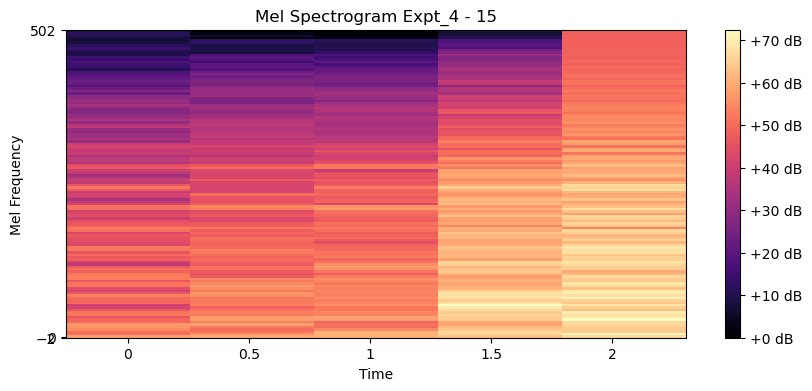

In [20]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# === ✅ 설정 ===
data_dir = "/home/crois-times/timeseries/projects/tool_wear_havard/data/dataverse_files/Dataset/T1/Acoustic_Emission_Data"
output_dir = "JJ/Harvard_Multimodal/Mel_spectrogram/T1"
num_splits = 540  # 생성할 Mel Spectrogram 개수
window_size = 1000  # STFT 윈도우 크기
desired_length = 2048  # 보간 후 신호 길이
sr = 1000  # 샘플링 레이트 (1000Hz, 동일한 조건 유지)
n_fft = 1000  # FFT 크기 (조건 유지)
hop_length = 512  # STFT hop 크기
n_mels = 128  # Mel 필터 개수
fmax = 500  # 저주파 강조 (고주파 영향 줄이기)

# 출력 폴더 생성
os.makedirs(output_dir, exist_ok=True)

# === ✅ Mel Spectrogram 변환 함수 ===
def generate_mel_spectrogram(signal, sr=1000, n_fft=1000, hop_length=512, n_mels=128, fmax=500):
    """Mel Spectrogram 변환 (저주파 강조)"""
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=0, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.min)  # 약한 신호도 강조
    return mel_spec_db

# === ✅ Expt_1~Expt_12 반복 ===
image_index = 1  # 전체 이미지 번호
for expt_idx in range(1, 13):  # Expt_1 ~ Expt_12
    file_path = os.path.join(data_dir, f"Expt_{expt_idx}.csv")
    
    # CSV 파일 읽기
    df = pd.read_csv(file_path)
    
    # Stride 계산 (겹치도록 자동 조정)
    stride = (len(df) - window_size) // (num_splits - 1)
    
    # 540개 Mel Spectrogram 생성
    for split_idx in range(num_splits):
        # 슬라이싱
        df_split = df.iloc[split_idx * stride : split_idx * stride + window_size].reset_index(drop=True)
        
        # 신호 데이터 (첫 번째 컬럼 사용)
        signal = df_split.iloc[:, 0].values
        
        # 보간 적용 (길이 맞추기)
        x_original = np.linspace(0, 1, len(signal))
        x_new = np.linspace(0, 1, desired_length)
        interpolator = interp1d(x_original, signal, kind='linear')
        signal_interpolated = interpolator(x_new)
        
        # Mel Spectrogram 변환
        melspec_db = generate_mel_spectrogram(signal_interpolated, sr, n_fft, hop_length, n_mels, fmax)
        
        # 시각화 및 저장
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(melspec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel Spectrogram Expt_{expt_idx} - {split_idx+1}")
        plt.xlabel("Time")
        plt.ylabel("Mel Frequency")
        
        # 파일 저장
        file_name = f"{image_index}_Expt_{expt_idx}.png"
        save_path = os.path.join(output_dir, file_name)
        plt.savefig(save_path)
        plt.close()
        
        # 이미지 인덱스 증가
        image_index += 1

print(f"Mel Spectrogram 생성 완료. 총 {image_index-1}개 이미지 저장됨.")
